In [1]:
# ** CHEQUEAR QUÉ LIBRERIAS ESTOY Y NO ESTOY USANDO** 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mtpl
#pip install plotly
import plotly.express as px
from scipy.interpolate import interp1d

from scipy import stats
import seaborn as sns
from scipy import signal
from sklearn.linear_model import LinearRegression

In [2]:
dust_file='Dust records corregidos Completo.xlsx'
temp_file='Temps records corregidos Completo.xlsx'

id_columns=['Name','Data id','Latitud','Longitud','Age units','Data units']

id_data=pd.read_excel(dust_file,sheet_name=0,usecols=id_columns)
#id_data=pd.read_excel(temp_file,sheet_name=0,usecols=id_columns)

df_data=pd.read_excel(dust_file,sheet_name=1,skiprows=1)
#df_data=pd.read_excel(temp_file,sheet_name=1,skiprows=1)

df_data

,Year,DustFlux,Year.1,DustFlux.1,Year.2,nssCa2 flux,Year.3,Ca2+,Year.4,Lithogenic,...,Year.8,DustFlux.5,Year.9,MAR,Year.10,DustConc,Year.11,Ca2+.1,Year.12,Part conc
0,4.509,602.784,0.375,0.259,1.19948,112.4,3.791,0.100000,0.620575,6.380517,...,1.15,238095.24,0.0,10.72,5.00,305.363666,7.8006,12.8,10.1479,60.539
1,4.552,423.903,0.400,0.329,1.21246,125.3,3.792,1.050000,0.827434,7.131424,...,2.20,238095.24,2.0,10.40,5.05,471.395055,7.8058,13.2,10.1555,73.720
2,4.690,299.095,0.425,0.652,1.22582,380.3,3.793,0.616667,1.034292,7.741062,...,3.25,277777.78,4.0,8.57,5.10,266.747998,7.8111,13.6,10.1631,52.932
3,5.259,734.449,0.450,0.341,1.23938,150.0,3.794,0.050000,1.241151,7.877875,...,4.15,265957.45,6.0,7.80,5.15,252.657484,7.8163,17.2,10.1707,76.469
4,5.674,603.242,0.475,0.312,1.25299,NaN,3.795,0.866667,1.448009,7.512894,...,5.09,263157.89,8.0,7.98,5.20,338.667402,7.8215,16.4,10.1781,56.083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64993,NaN,NaN,NaN,NaN,NaN,NaN,149.949,5.600000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64994,NaN,NaN,NaN,NaN,NaN,NaN,149.960,5.200000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64995,NaN,NaN,NaN,NaN,NaN,NaN,149.971,5.200000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64996,NaN,NaN,NaN,NaN,NaN,NaN,149.982,5.400000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#SEPARAR CADA UNA DE LAS COLUMNAS v.2
columns=df_data.size/len(df_data)
lis=[] 
new_length=np.array([])

for i in range(int(columns)):
    if (i+1)%2==1: 
        dupla=df_data[[df_data.columns[i],df_data.columns[i+1]]].dropna()
        dupla.index=[j for j in range(0, len(dupla))]
        lis.append(dupla)
        new_length=np.append(new_length,np.shape(dupla)[0])



### Sería interesante tambien promediar los epsilons para cada K, y  plotear el promedio de conjunto para distintos pasos de tiempo.
No se si tiene sentido hablar de pasos de tiempo si es que solo avanzo en samples... quizás simplemente sacar los gráficos para distintos K (hacer funcion)

In [4]:
font = {'family' : 'serif',
        'weight' : 'ultralight',
        'size'   : 14}

mtpl.rc('font', **font)

In [5]:
for i in range(len(lis)):
    print(len(lis[i]))

507
31838
2242
60616
2384
192
254
105
722
1801
1744
3038
2728


In [58]:
k=2
k_half=int(k/2)
data=[1,2,3,4,5,6,7,8,9,10]
print(data)
print(np.roll(data,-k_half)[:-k])
print(data[:-k],'\n')

print(np.roll(data,-k)[:-k])
print(data[:-k])

#print(np.roll(data,-k_half)[:-k]-data[:-k])
#print(np.roll(data,-k)[:-k]-data[:-k])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[2 3 4 5 6 7 8 9]
[1, 2, 3, 4, 5, 6, 7, 8] 

[ 3  4  5  6  7  8  9 10]
[1, 2, 3, 4, 5, 6, 7, 8]


In [49]:
# data= lis[i][lis[i].columns[0]]
def epsilon_ratio(data,k):
    k_half=int(k/2)
    numerador=np.roll(data,-k_half)[:-k]-data[:-k]
    denominador=np.roll(data,-k)[:-k]-data[:-k]
    eps=numerador/denominador
    #print(round(np.count_nonzero((eps<0.25)|(0.75<eps))/len(data)*100,1),'% outside [\u03B5 min, 1-\u03B5 min]')
    points_outside=(np.count_nonzero((eps<0.25)|(0.75<eps)))
    #print('k = ',k,'        n°points',points_outside,' out of ',len(data),' = ',points_outside/len(data)*100,'%')
    return eps,points_outside

36.1 % outside [ε min, 1-ε min]


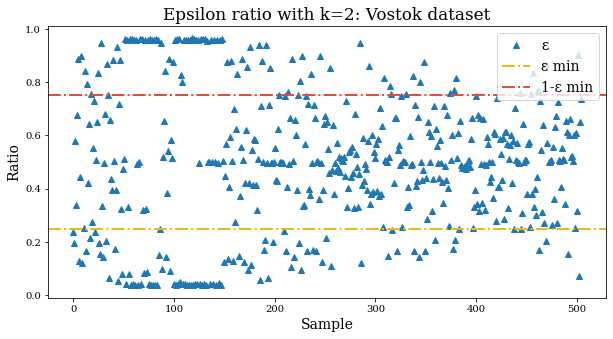

0.2 % outside [ε min, 1-ε min]


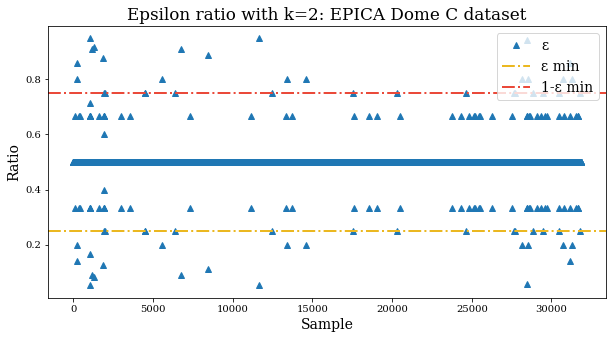

0.2 % outside [ε min, 1-ε min]


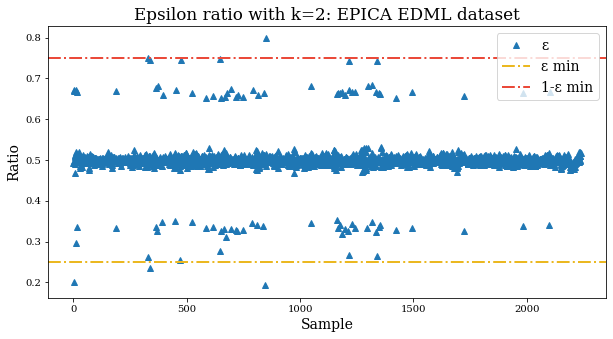

1.9 % outside [ε min, 1-ε min]


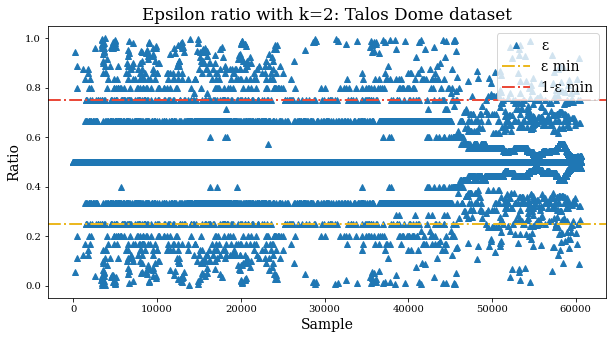

0.9 % outside [ε min, 1-ε min]


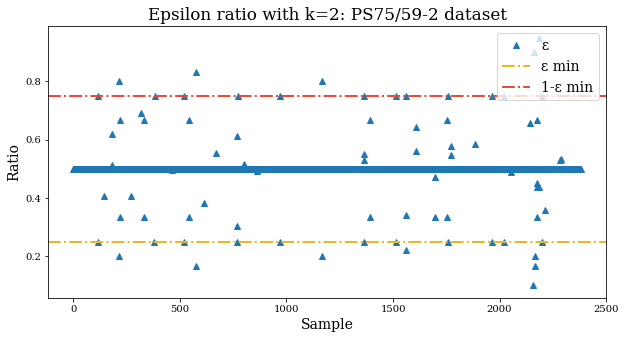

2.6 % outside [ε min, 1-ε min]


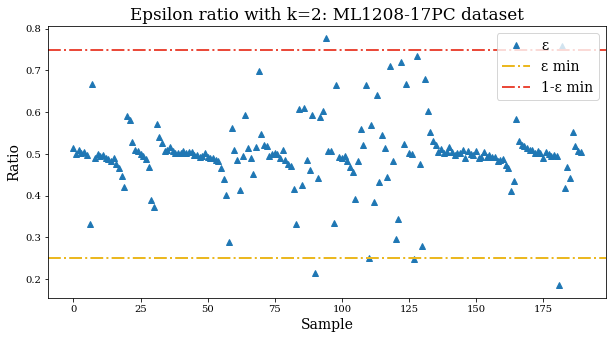

2.0 % outside [ε min, 1-ε min]


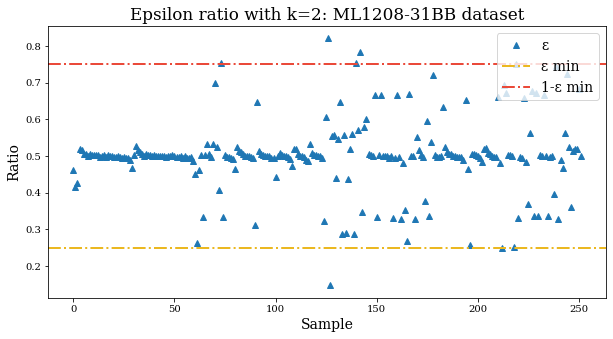

5.7 % outside [ε min, 1-ε min]


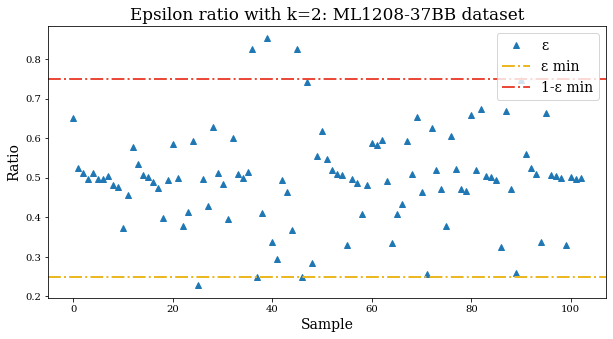

0.3 % outside [ε min, 1-ε min]


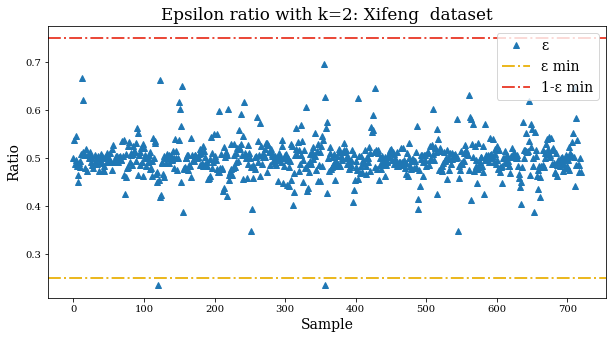

0.0 % outside [ε min, 1-ε min]


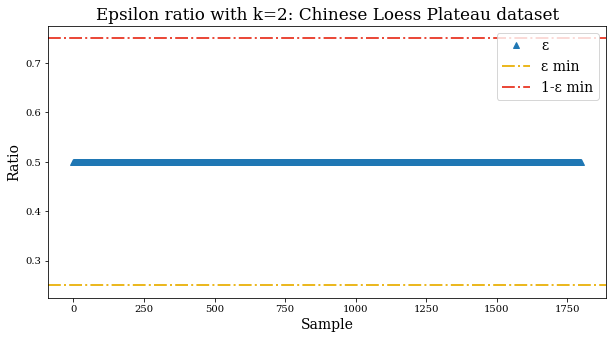

3.4 % outside [ε min, 1-ε min]


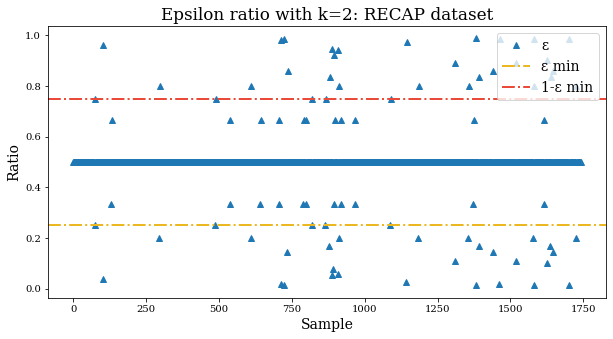

0.3 % outside [ε min, 1-ε min]


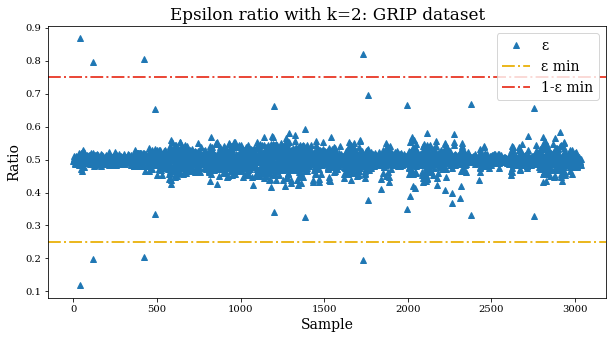

0.8 % outside [ε min, 1-ε min]


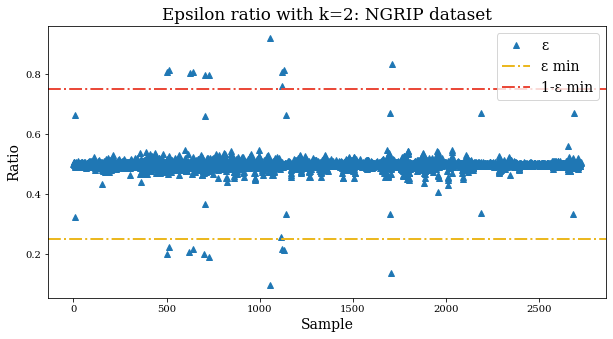

In [29]:
k=2
for i in range(len(lis)):
    plt.subplots(figsize=(10, 5))
    
    plt.plot(epsilon_ratio(lis[i][lis[i].columns[0]],k)[0],'^',label='\u03B5')    
    plt.axhline(y=0.25, color='#EBB821', linestyle='-.',linewidth=2,label='\u03B5 min')
    plt.axhline(y=0.75, color='#EA4A3A', linestyle='-.',linewidth=2,label='1-\u03B5 min')
    
    plt.title('Epsilon ratio with k='+str(k)+': '+id_data['Name'][i]+' dataset')
    plt.xlabel('Sample')
    plt.ylabel('Ratio')
    
    mtpl.rc('xtick', labelsize=10) 
    mtpl.rc('ytick', labelsize=10) 
    plt.legend(loc='upper right')
    
    #try:
    #    plt.savefig(str(i+1)+'-Temp Epsilon plot '+id_data['Name'][i]+'.pdf')
    #except:
    #    plt.savefig(str(i+1)+'-Temp Epsilon plot PS7559-2.pdf')
    
    plt.show()

In [ ]:
#Plot k vs points outside range

In [46]:
for i in range(len(lis)):
    #print('\n-------- Data n° ',i,'   -------')
    k=2
    print(len(lis[i][lis[i].columns[0]])%2)
    #print((len(lis[i][lis[i].columns[0]])-len(lis[i][lis[i].columns[0]])%2))
#    while k<=(len(lis[i][lis[i].columns[0]])-len(lis[i][lis[i].columns[0]])%2):

1
0
0
0
0
0
0
1
0
1
0
0
0


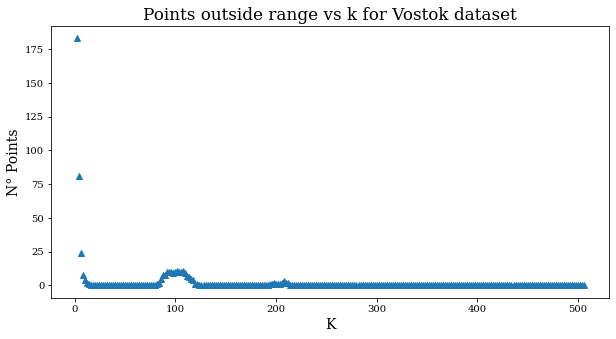

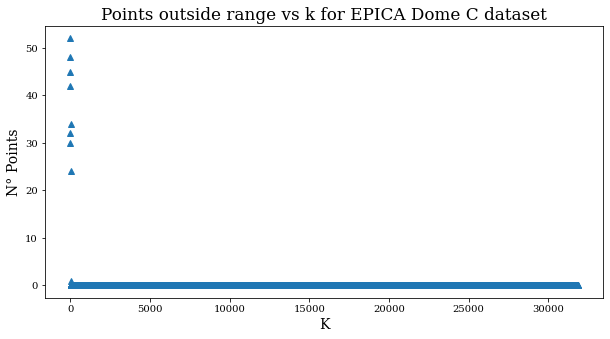

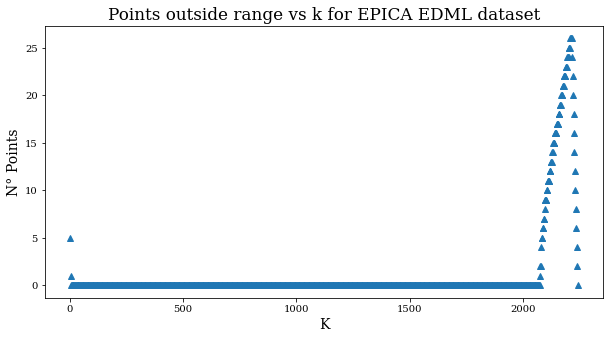

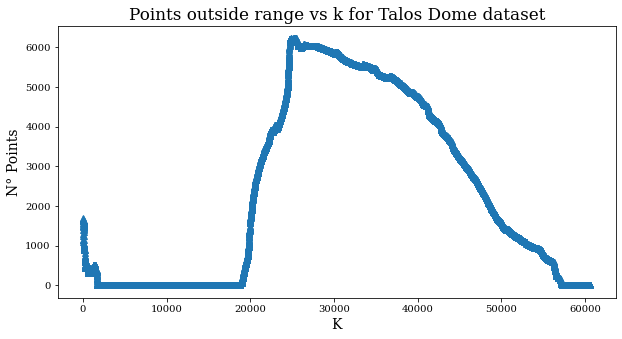

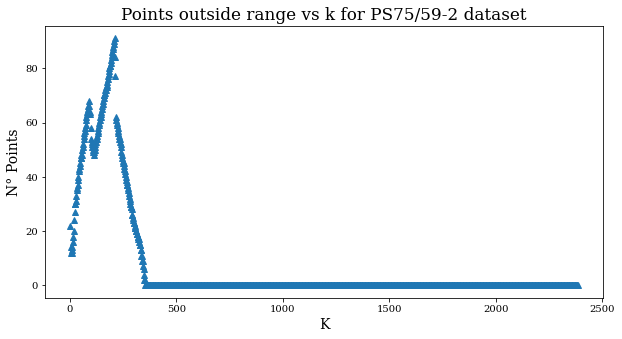

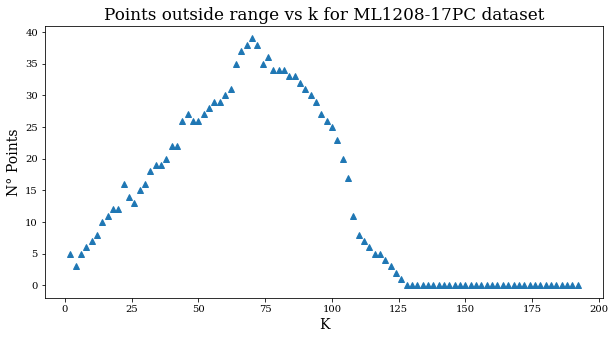

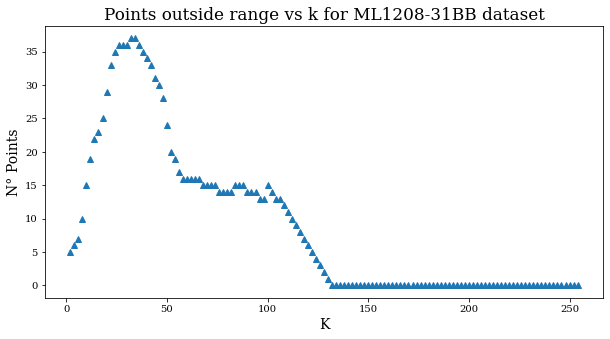

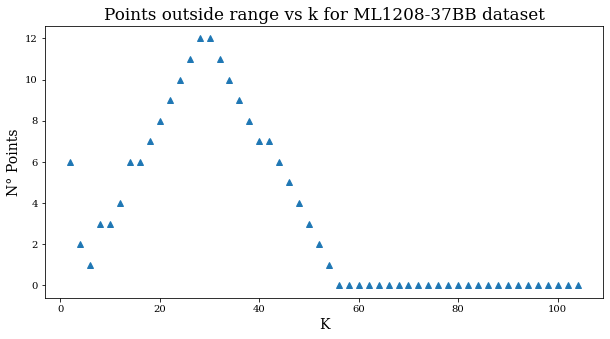

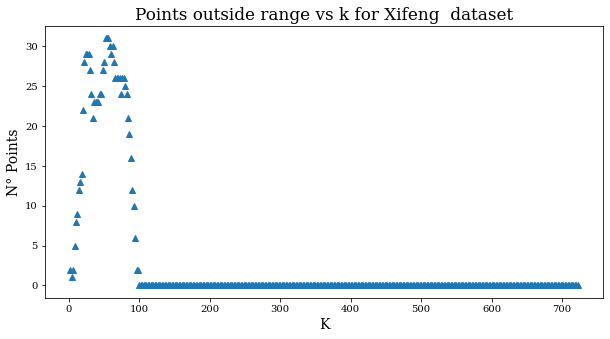

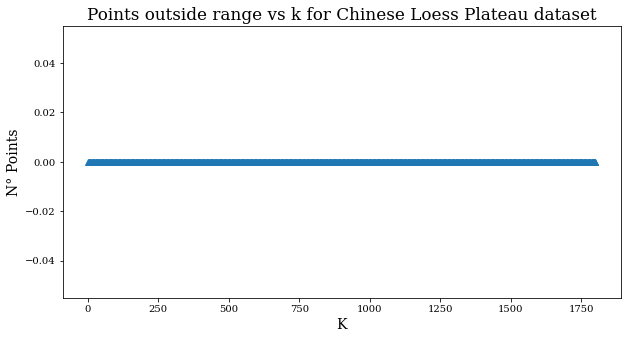

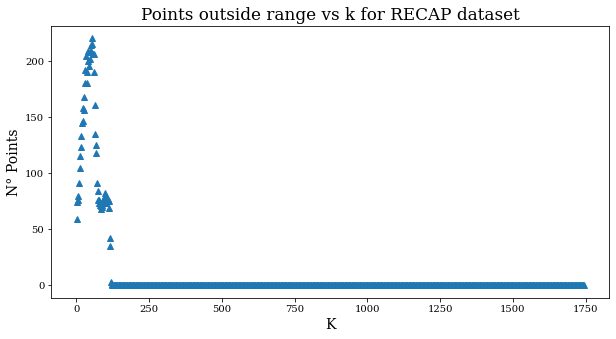

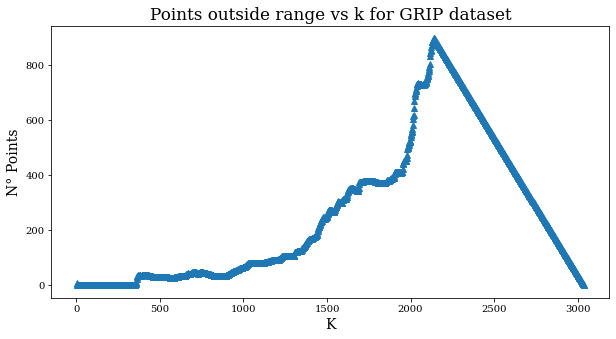

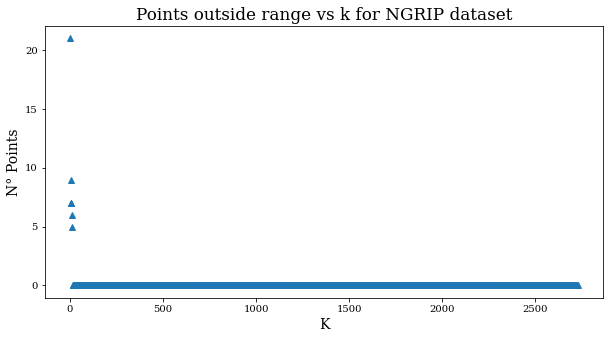

In [50]:
for i in range(len(lis)):
    #print('\n-------- Data n° ',i,'   -------')
    k=2
    list_points=np.array([])
    list_ks=np.array([])
    while k<=(len(lis[i][lis[i].columns[0]])-len(lis[i][lis[i].columns[0]])%2):
        points=epsilon_ratio(lis[i][lis[i].columns[0]],k)[1]
        list_points=np.append(list_points,points)
        list_ks=np.append(list_ks,k)
        #print('k: ', k, '    points outside range: ',points)
        #ratios_ave=np.append(ratios_ave,prom)
        #if prom<=0.25:
        #    k=len(data)
        k+=2

    plt.subplots(figsize=(10, 5))
    
    plt.plot(list_ks,list_points,'^')#,label='\u03B5')    
    #plt.axhline(y=0.25, color='#EBB821', linestyle='-.',linewidth=2,label='\u03B5 min')
    #plt.axhline(y=0.75, color='#EA4A3A', linestyle='-.',linewidth=2,label='1-\u03B5 min')
    
    plt.title('Points outside range vs k for '+id_data['Name'][i]+' dataset')
    plt.xlabel('K')
    plt.ylabel('N° Points')
    
    #mtpl.rc('xtick', labelsize=10) 
    #mtpl.rc('ytick', labelsize=10) 
    #plt.legend(loc='upper right')
    
    
    
    #try:
    #    plt.savefig(str(i+1)+'-Temp Epsilon plot '+id_data['Name'][i]+'.pdf')
    #except:
    #    plt.savefig(str(i+1)+'-Temp Epsilon plot PS7559-2.pdf')
    
    plt.show()

In [41]:
list_points

array([183.,  81.,  24.,   8.,   4.,   2.,   1.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   2.,   5.,   8.,
         8.,  10.,  10.,  10.,   9.,  10.,  11.,  10.,  10.,  11.,   9.,
         7.,   6.,   5.,   4.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   2.,
         1.,   1.,   1.,   2.,   3.,   2.,   2.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

In [42]:
list_ks

array([  2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,  22.,
        24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,  44.,
        46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,  66.,
        68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,  88.,
        90.,  92.,  94.,  96.,  98., 100., 102., 104., 106., 108., 110.,
       112., 114., 116., 118., 120., 122., 124., 126., 128., 130., 132.,
       134., 136., 138., 140., 142., 144., 146., 148., 150., 152., 154.,
       156., 158., 160., 162., 164., 166., 168., 170., 172., 174., 176.,
       178., 180., 182., 184., 186., 188., 190., 192., 194., 196., 198.,
       200., 202., 204., 206., 208., 210., 212., 214., 216., 218., 220.,
       222., 224., 226., 228., 230., 232., 234., 236., 238., 240., 242.,
       244., 246., 248., 250., 252., 254., 256., 258., 260., 262., 264.,
       266., 268., 270., 272., 274., 276., 278., 280., 282., 284., 286.,
       288., 290., 292., 294., 296., 298., 300., 30

Voy a tratar de hace un promedio para distintos K's

In [79]:
data=lis[0][lis[0].columns[0]]

In [80]:
len(data)

1879

In [102]:
k=2
ratios_ave=np.array([])
print(len(ratios_ave))
while k<=(len(data)-len(data)%2):
    prom=np.mean(epsilon_ratio(data,k))
    ratios_ave=np.append(ratios_ave,prom)
    if prom<=0.25:
        k=len(data)
    k+=2
print(len(ratios_ave))

0
490


6114

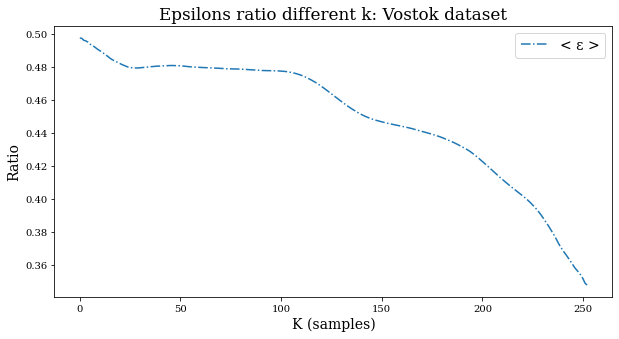

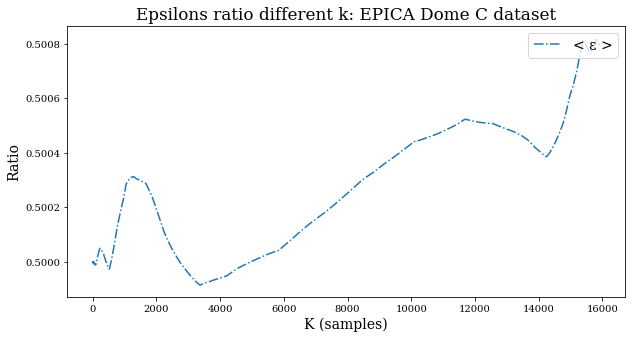

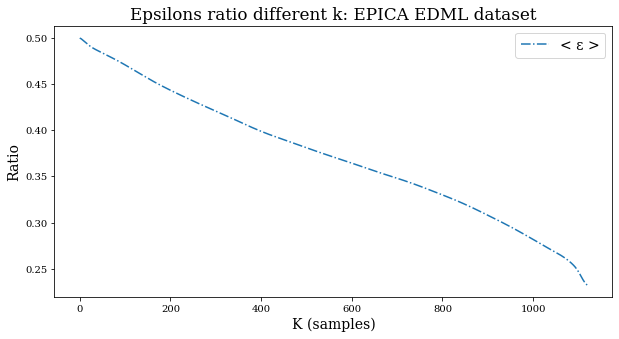

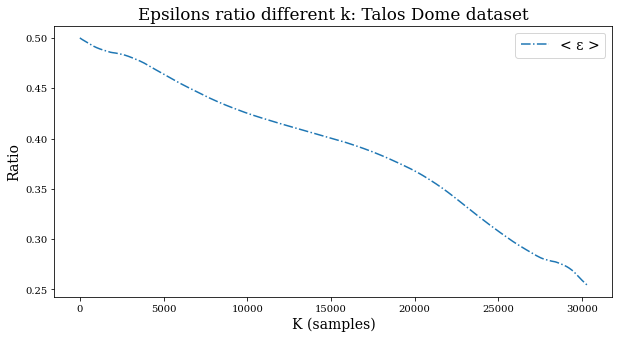

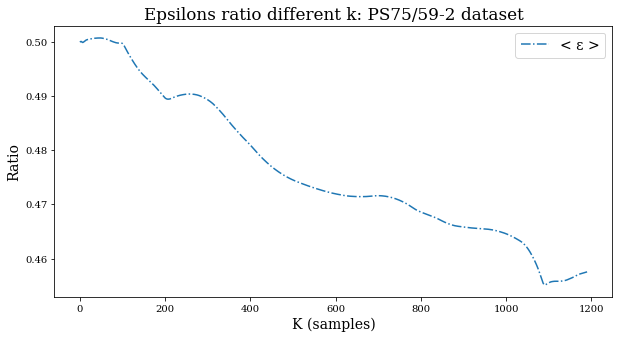

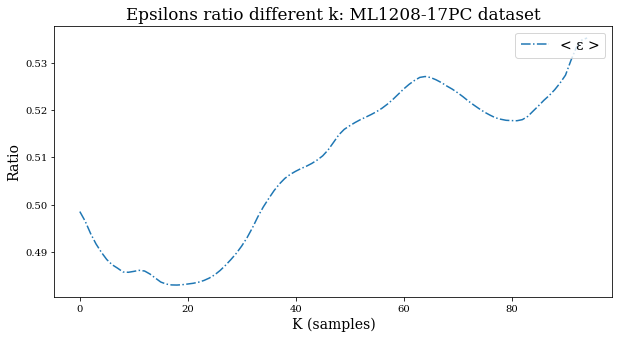

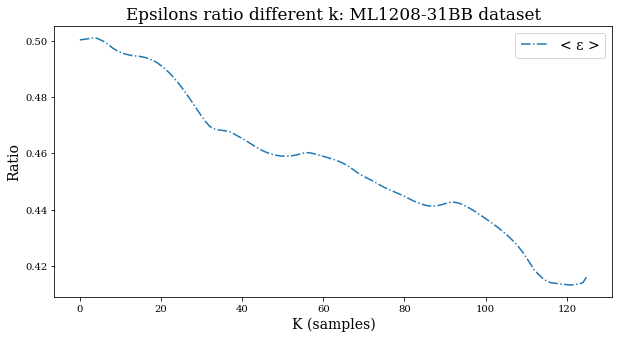

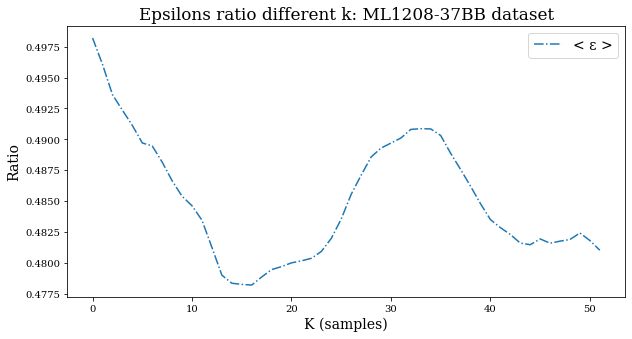

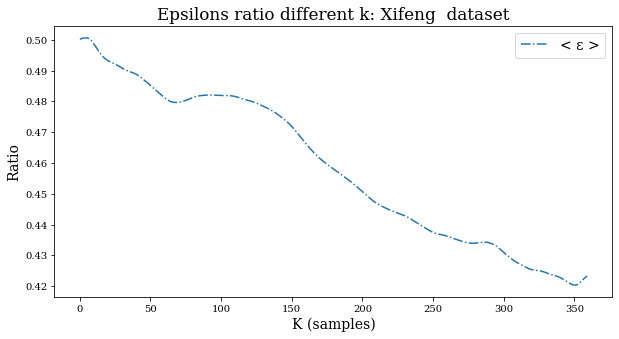

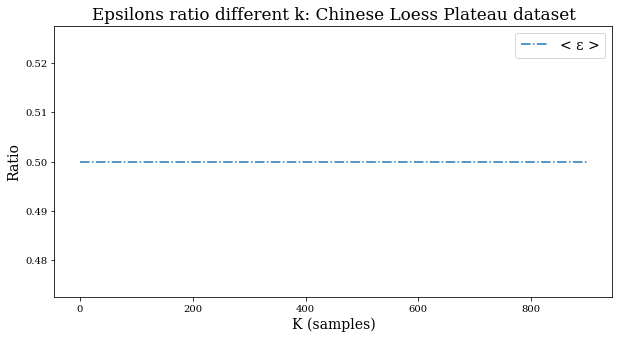

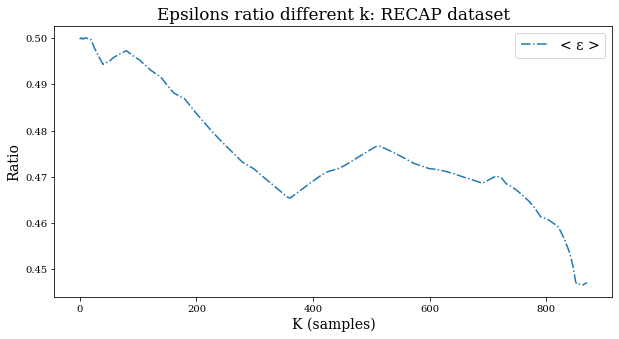

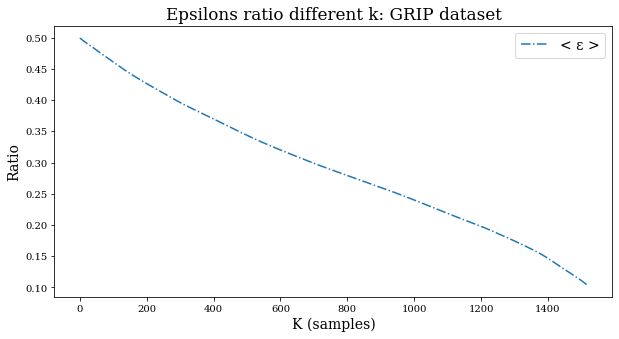

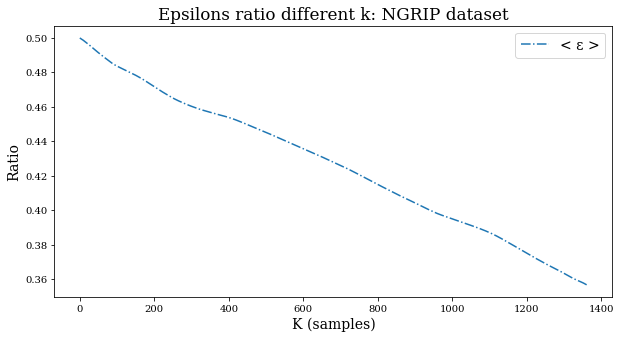

In [134]:

for i in range(len(lis)):
    k=2
    ratios_ave=np.array([])
    while k<=(len(lis[i][lis[i].columns[0]])-len(lis[i][lis[i].columns[0]])%2):
        
        prom=np.mean(epsilon_ratio(lis[i][lis[i].columns[0]],k))
        ratios_ave=np.append(ratios_ave,prom)
        k+=2
    
    plt.subplots(figsize=(10, 5))
    plt.plot(ratios_ave,'-.',label='< \u03B5 >')    
    #plt.axhline(y=0.25, color='#EBB821', linestyle='-.',linewidth=2,label='\u03B5 min')
    #plt.axhline(y=0.75, color='#EA4A3A', linestyle='-.',linewidth=2,label='1-\u03B5 min')

    plt.title('Epsilons ratio different k: '+id_data['Name'][i]+' dataset')
    
    plt.xlabel('K (samples)')
    plt.ylabel('Ratio')

    mtpl.rc('xtick', labelsize=10) 
    mtpl.rc('ytick', labelsize=10) 
    plt.legend(loc='upper right')
    plt.show()

In [93]:
años_promediados = pd.DataFrame(age_filtrados, columns = ['Year'])
valores_promediados = pd.DataFrame(val_filtrados, columns = ['Values'])
base_corregida=pd.concat([años_promediados,valores_promediados], axis=1)

base_corregida.to_excel('Vostok filtrado.xlsx')